# 03、手写字体识别

上一节我们新建了一个多层感知机，对整个流程有了大体的印象，其中我们使用了nn.Sequential()来对模型进行定义，与nn.Sequential()类似的API还有ModuleList，ModuleDict，他们都是继承于nn.Module,一个通用组件，下面将对Sequential、ModuleList，ModuleDict进行介绍，然后最后介绍nn.Module,并使用其构建自定义模型。
## 1.Sequential

   其中使用自定义模型的API，net = nn.Sequential()，Sequential是一个有序的容器，网络层将按照在传入Sequential的顺序依次添加到计算图中，除此之外还有其他定义模型的方法：
1. 方法一
net = nn.Sequential(nn.Linear(n_input, 1))
2. 方法二
net = nn.Sequential()
net.add_module('linear',nn.Linear(n_input, 1))
3. 方法三
net = nn.Sequential(
    OrderedDict([
        ('linear',nn.Linear(10,10)),
        ('linear',nn.Linear(10,1))]
    )
)

In [14]:
# 1. 方法一,直接在Sequential()中添加网络层，网络层会直接进行堆叠，注意输出与输入的维度关系，如下代码所示
import torch
from torch import nn
net = nn.Sequential(nn.Linear(10, 10), nn.Linear(10, 1))
net

Sequential(
  (0): Linear(in_features=10, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=1, bias=True)
)

In [17]:
# 2. 方法二，实例完对象后调用其add_module,传入层的名字和层对象即可，注意：如果名字是一样的就会看作一个整体
net = nn.Sequential()
net.add_module('my_linear',nn.Linear(10, 10))
net.add_module('my_linear_2',nn.Linear(10, 1))
net

Sequential(
  (my_linear): Linear(in_features=10, out_features=10, bias=True)
  (my_linear_2): Linear(in_features=10, out_features=1, bias=True)
)

In [19]:
# 3. 方法三，传入一个有序字典，其中OrderedDict需要传入一个列表，其中列表中包括层名称与层对象的元组
from collections import OrderedDict
import torch
from torch import nn
net = nn.Sequential(
    OrderedDict([
        ('linear_1',nn.Linear(10,10)),           
        ('linear_2',nn.Linear(10,1))]
    )
)
net

Sequential(
  (linear_1): Linear(in_features=10, out_features=10, bias=True)
  (linear_2): Linear(in_features=10, out_features=1, bias=True)
)

综上所述，Sequential()在构建简单的模型时很方便，除了Sequential()以外还有其他的方法对模型进行定义，ModuleList,ModuleDict

## 2.ModuleList
ModuleList像python的list列表一样，传入列表对象，然后可以使用append,extend对网络进行操作，可以对网络进行索引。

In [21]:
net = nn.ModuleList([nn.Linear(784, 256), nn.ReLU()])
net

ModuleList(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
)

## 3.ModuleDict
ModuleDict像python的dict字典一样，传入字典对象，然后可以像操作字典一样对网络进行操作。

In [26]:
net = nn.ModuleDict({
    'linear':nn.Linear(784, 256),
    'act':nn.ReLU(),
    'linear2':nn.Linear(256, 10)
})
net['out'] = nn.Linear(10, 1)
net['linear2'] # 访问网络的某一层

Linear(in_features=256, out_features=10, bias=True)

## 4.nn.Module
nn.Module可以构建更加复杂的网络，首先我们需要自定义一个类，继承nn.Module，然后重写__init__方法，和forward函数，__init__ 是对网络的层进行简单的定义，然后forward函数是对网络的前向计算进行规定，因为我们上面介绍了很多构建模型的方法，在构建复杂模型时可以进行任意组合构建我们需要的模型。

In [29]:
class Model(nn.Module):
    def __init__(self, num_input, num_output):
        super(Model, self).__init__()
        self.liner1 = nn.Linear(num_input, 100)
        self.liner2 = nn.Linear(100, 50)
        self.liner3 = nn.Linear(50, num_output)

    def forward(self, x):
        y = self.liner1(x.view(-1, 784))
        y = self.liner2(y)
        y = self.liner3(y)
        return y
net = Model(784, 10)
net

Model(
  (liner1): Linear(in_features=784, out_features=100, bias=True)
  (liner2): Linear(in_features=100, out_features=50, bias=True)
  (liner3): Linear(in_features=50, out_features=10, bias=True)
)

In [31]:
# 与Sequential配合使用

class Model_Se(nn.Module):
    def __init__(self, num_input, num_output):
        super(Model_Se, self).__init__()
        self.net = nn.Sequential(nn.Linear(num_input, 100),
                                 nn.Linear(100, 50),
                                 nn.Linear(50, num_output))
    def forward(self, x):
        y = self.net(x.view(-1, 784))
        return y
net = Model_Se(784, 10)
net

Model_Se(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

更复杂的使用，读者可以自己进行尝试，以不变应万变对于复杂模型见招拆招。

## 训练过程
这一小节我们主要介绍，torchvison自带的数据集处理接口，torchvision.datasets,提供了大量的数据集接口，只需一行代码就可以下载数据集，供下一步进行处理。支持的数据集有：

MNIST、Fashion-MNIST、KMNIST、EMNIST、QMNIST、FakeData、COCO、Captions、Detection、LSUN、ImageFolder、DatasetFolder、ImageNet、CIFAR、STL10
、SVHN、PhotoTour、SBU、Flickr、VOC、Cityscapes、SBD、USPS、Kinetics-400、HMDB51、UCF101

参考：https://pytorch.org/docs/master/torchvision/datasets.html#torchvision-datasets

然后我们使用torch.utils.data.DataLoader来将数据集转换成迭代器类型，在训练的时候可以不断的生成数据，供训练使用。这一节使用的MNIST可以使用API，torchvision.datasets.MNIST(),来获取，你需要传入的参数有root，下载数据放置的文件夹，train默认True，是否使用训练数据, transform默认None,是对训练集进行处理，数据增强，target_transform默认None,是否对标签数据进行处理，download默认False，是否需要下载数据集，torchvision.datasets.MNIST()API构建了getitem方法你可以使用for循环对数据进行迭代获取。光获取数据也可以直接进行训练，但是不方便进行批次处理和shuffle操作，所以我们需要torch.utils.data.DataLoader将获取到的数据可迭代对象传入，然后进行shuffle和batch_size获取经过shuffle的批次数据，使用根据官方文档可知 
>我们可迭代样式的数据集是IterableDataset 实现__iter__()协议的子类的实例，并且表示数据样本上的可迭代。这种类型的数据集特别适用于随机读取价格昂贵甚至不大可能，并且批处理大小取决于所获取数据的情况。例如，这样的数据集称为时iter(dataset)，可以返回从数据库，远程服务器甚至实时生成的日志中读取的数据流。

后续会讲到自定义数据，到时我们将对构建数据集的方法进行进一步详细介绍。

参考：https://pytorch.org/docs/master/_modules/torch/utils/data/dataloader.html#DataLoader

In [1]:
import torch
from torchvision import datasets
from torch import nn
from torchvision.transforms import transforms
import torch.optim as optim
import torch.nn.functional as F
transform = transforms.Compose([
    transforms.ToTensor(),

])

trainset = datasets.MNIST(root='./data', train=True,
                          download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True)


testset = datasets.MNIST(root='./data', train=False,
                         download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False)

In [2]:
class Model(nn.Module):
    def __init__(self, num_input, num_output):
        super(Model, self).__init__()
        self.linear = nn.Linear(784, 10)

    def forward(self, x):
        x = x.view(-1,784)
        y = F.relu(self.linear(x))
        return y


model = Model(784, 10)

In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs = 10

In [4]:
# 在训练过程中一般一个轮次训练结束后对测试集整体进行测试，获取测试集上的损失和准确率
losses = []
acces = []
eval_losses = []
eval_acces = []
for e in range(epochs):
    train_loss = 0
    train_acc = 0
    model.train() 
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()   
        _, pred = output.max(1)
        # 计算一个批次对了几个
        num_correct = (pred == target).sum().item()
        # 计算准确率=对的个数/批次大小
        acc = num_correct / data.shape[0]
        train_acc += acc
    # 统计一个轮次中平均损失与平均准确率
    losses.append(train_loss / len(trainloader.dataset))
    acces.append(train_acc / len(trainloader))
    eval_loss = 0
    eval_acc = 0
    model.eval() # 将模型改为预测模式
    with torch.no_grad():
        for im, label in testloader:
            out = model(im)
            loss = criterion(out, label)
            # 记录误差
            eval_loss += loss.item()
            # 记录准确率
            _, pred = out.max(1)
            num_correct = (pred == label).sum().item()
            acc = num_correct / im.shape[0]
            eval_acc += acc
        # 上面的代码对全部的测试集进行测试，下面两行就是讲这一次的整个测试集的损失和准确率存在列表里,如果进行可视化可能会用到
        eval_losses.append(eval_loss / len(testloader.dataset))
        eval_acces.append(eval_acc / len(testloader))
        print('Epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}, Eval Loss: {:.6f}, Eval Acc: {:.6f}'
              .format(e, train_loss / len(trainloader), train_acc / len(trainloader), 
                     eval_loss / len(testloader), eval_acc / len(testloader)))

Epoch: 0, Train Loss: 1.236565, Train Acc: 0.701559, Eval Loss: 0.846345, Eval Acc: 0.791600
Epoch: 1, Train Loss: 0.777234, Train Acc: 0.795592, Eval Loss: 0.582031, Eval Acc: 0.877787
Epoch: 2, Train Loss: 0.520676, Train Acc: 0.875650, Eval Loss: 0.448927, Eval Acc: 0.887440
Epoch: 3, Train Loss: 0.450944, Train Acc: 0.884478, Eval Loss: 0.408207, Eval Acc: 0.893710
Epoch: 4, Train Loss: 0.418709, Train Acc: 0.889676, Eval Loss: 0.385099, Eval Acc: 0.898587
Epoch: 5, Train Loss: 0.398569, Train Acc: 0.893507, Eval Loss: 0.369252, Eval Acc: 0.902170
Epoch: 6, Train Loss: 0.383794, Train Acc: 0.896172, Eval Loss: 0.357137, Eval Acc: 0.904359
Epoch: 7, Train Loss: 0.372628, Train Acc: 0.898587, Eval Loss: 0.348797, Eval Acc: 0.906250
Epoch: 8, Train Loss: 0.363811, Train Acc: 0.900770, Eval Loss: 0.341359, Eval Acc: 0.908240
Epoch: 9, Train Loss: 0.356558, Train Acc: 0.902086, Eval Loss: 0.335352, Eval Acc: 0.909435


**补充说明：**

在训练过程中，需要设置model.train()让模型处于训练状态其作用是启用BN和Dropout,在进行验证操作时需要设置为model.eval()虽然现在不设置也没关系，随后随着模型的复杂化当使用到BN和Dropout是切记设置正确参数。

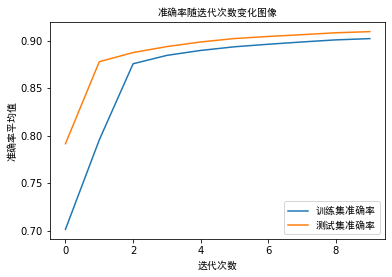

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
# acces
# eval_acces
myfont = FontProperties(fname='C:/Windows/Fonts/simhei.ttf')
h1, = plt.plot([x for x in range(len(acces))], acces, label="训练集准确率")
h2, = plt.plot([y for y in range(len(eval_acces))], eval_acces, label="测试集准确率")
plt.title('准确率随迭代次数变化图像', fontproperties=myfont)
plt.xlabel('迭代次数', fontproperties=myfont)
plt.ylabel('准确率平均值', fontproperties=myfont)
plt.legend(handles=[h1,h2],labels=['训练集准确率','测试集准确率'],prop=myfont)
plt.show()